# Modeling with all features with RFE

_This notebook will take almost all the numerical and categorical features, apply Polynomial Features and One-Hot Encoding, and then boil down the necessary coefficients with Recursive Feature ELimination._

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFE

%matplotlib inline

In [2]:
train = pd.read_csv('../datasets/train_clean.csv')
test = pd.read_csv('../datasets/test_clean.csv')

In [3]:
X = train[['Lot Frontage',
 'Overall Qual',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'Total Bsmt SF',
 '1st Flr SF',
 'Gr Liv Area',
 'Full Bath',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Yr Blt',
 'Garage Cars',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF']]

y = train['SalePrice']

X_final = test[['Lot Frontage',
 'Overall Qual',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'Total Bsmt SF',
 '1st Flr SF',
 'Gr Liv Area', 
 'Full Bath',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Yr Blt',
 'Garage Cars',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF']]

In [5]:
# Read datasets where dummies were already made
X_dummies = pd.read_csv('../datasets/train_dummies.csv')
X_final_dummies = pd.read_csv('../datasets/test_dummies.csv')

In [6]:
# Using polynomial features to get the interaction and squared terms for the 
# numeric columns
pf = PolynomialFeatures(degree = 2, include_bias = False)
X = pd.DataFrame(pf.fit_transform(X))
X_final = pd.DataFrame(pf.transform(X_final))

In [7]:
# Concatenating to one large set of data for training and testing
X = pd.concat([X, X_dummies], axis = 1, sort=False)
X_final = pd.concat([X_final, X_final_dummies], axis = 1, sort = False)

In [8]:
# Train-test-split of train data
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

In [9]:
# Standardizing the X_train, X_test, X_final
ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train)
X_test_scale = ss.transform(X_test)
X_final_scale = ss.transform(X_final)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


_At this point, I initiated the Recursive Feature Elimination to remove the features that are not having a big impact on the model. As a general rule of thumb, we want square root entries as the max number of features. Since we have 2051 entries, I found the square root of 2051 to be about 45. However, I decided to use a GridSearch function to help me find the best amount of features to select._

In [42]:
%%time

rfe_params = {
    'n_features_to_select' : np.arange(36, 46, 2)
}

grid = GridSearchCV(
    RFE(estimator=LinearRegression()),
    rfe_params,
    cv = 3,
    verbose = 1,
    return_train_score = True
)

grid.fit(X_train_scale, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.2min finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 2min 34s, sys: 2.09 s, total: 2min 36s
Wall time: 1min 17s


In [43]:
grid.best_estimator_

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
  n_features_to_select=38, step=1, verbose=0)

In [44]:
grid.best_estimator_.score(X_test_scale,y_test)

0.8872988268890766

In [45]:
preds = grid.best_estimator_.predict(X_test_scale)

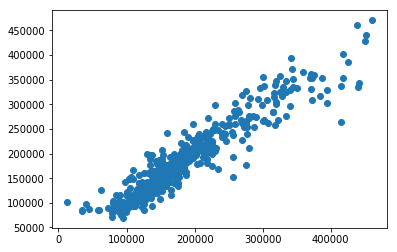

In [46]:
plt.scatter(y_test, preds)

In [62]:
y_grid = grid.best_estimator_.predict(X_final_scale)

In [47]:
lasso = LassoCV(n_alphas = 200)

In [48]:
lasso.fit(X_train_scale,y_train)
lasso.score(X_test_scale, y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

0.9048393426947614

In [55]:
y_preds = lasso.predict(X_test_scale)

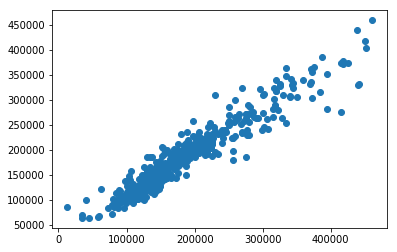

In [56]:
plt.scatter(y_test, y_preds)

In [63]:
y_lasso = lasso.predict(X_final_scale)

In [54]:
submission = test[['Id']]
submission['SalePrice'] = y_hat
submission.to_csv('../submissions/submission20.csv', index=False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


_After this point, I decided to try to use a combination of all the other regression models and to find the average of a few._

In [52]:
submission1 = test[['Id']]
submission1['SalePrice'] = y_preds
submission1.to_csv('../submissions/submission21.csv', index=False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [60]:
submission2 = test[['Id']]
submission2['SalePrice'] = (y_preds + y_hat)/2
submission2.to_csv('../submissions/submission22.csv', index=False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [64]:
ridge = RidgeCV(alphas=[0.001, 0.01, 0.1, 1])
ridge.fit(X_train_scale, y_train)
ridge.score(X_test_scale, y_test)

0.8762241820591196

In [65]:
y_ridge = ridge.predict(X_final_scale)

In [69]:
enet = ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1], n_alphas = 100)
enet.fit(X_train_scale, y_train)
enet.score(X_test_scale, y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

0.9053467896507965

In [70]:
y_enet = enet.predict(X_final_scale)

In [76]:
lr = LinearRegression()
lr.fit(X_train_scale, y_train)
lr.score(X_test_scale, y_test)

0.8694172580215662

In [77]:
y_lr = lr.predict(X_final_scale)

In [72]:
sub3 = test[['Id']]
sub3['SalePrice'] = (y_grid + y_lasso + y_ridge + y_enet)/4
sub3.to_csv('../submissions/submission23.csv', index=False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [73]:
sub4 = test[['Id']]
sub4['SalePrice'] = (y_enet + y_lasso)/2
sub4.to_csv('../submissions/submission24.csv', index=False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [74]:
sub5 = test[['Id']]
sub5['SalePrice'] = (y_grid + y_ridge)/2
sub5.to_csv('../submissions/submission25.csv', index=False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [78]:
sub6 = test[['Id']]
sub6['SalePrice'] = (y_grid + y_lasso + y_ridge + y_enet + y_lr)/5
sub6.to_csv('../submissions/submission26.csv', index=False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
